# **1) Imports and connection to Google services**

In [ ]:
# -*- coding: utf-8 -*-
# Code to read csv file into Colaboratory:
from google.colab import drive
drive.mount('/content/drive')
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Word2Vec installations
!pip install fasttext
!pip install gensim
!pip install sklearn

from fasttext import train_supervised
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn 
from gensim.models.fasttext import FastText
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import string
import nltk
from nltk.corpus import stopwords
from io import StringIO
import csv
import time

print('\n***********************\nCompleted\n***********************') 

Mounted at /content/drive
     |████████████████████████████████| 68 kB 3.3 MB/s 
  Using cached pybind11-2.8.1-py2.py3-none-any.whl (208 kB)
  Created wheel for fasttext: filename=fasttext-0.9.2-cp37-cp37m-linux_x86_64.whl size=3121498 sha256=0ee8fd86ee7f84069464b6f257bb43c7a6bc641b8e0fde3fbd2effc5ebdc2e10
  Stored in directory: /root/.cache/pip/wheels/4e/ca/bf/b020d2be95f7641801a6597a29c8f4f19e38f9c02a345bab9b
Successfully built fasttext

***********************
Completed
***********************


# **2) Parameters & data importing**

In [ ]:
dir = '/content/drive/MyDrive/Thèse Lévothyrox/2 JP Colab Notebooks/data/' # Files directory (in/out)

embedding_size = 60
window_size = 20 #40
min_word = 3
down_sampling = 1e-2
test_size = 0.2                             # test/(test+train)
nbiter = 50
# Limiting datasets size during test phase
max_tweets = 10000                          # Or None
max_texts = None                             # Or None

df = pd.read_csv(dir + 'dataset_doctissimo_updated.csv')

# Limit size for initial testing
if not max_texts is None:
    df = df.sample(n=max_texts)

In [ ]:
df[df['year']==2020]

,date,user,text,url,year,words_count
0,2020-03-21,freesia53,suivre thyroidite hasimoto deconvenue levothyr...,https://forum.doctissimo.fr/sante/thyroide-pro...,2020,52
1,2020-03-13,petitbouch​on,medecin prescrit hypothyroidie secondaire tsh ...,https://forum.doctissimo.fr/sante/thyroide-pro...,2020,16
2,2020-03-13,Susanne in F,equivalent pifometre savoir exactement dosage ...,https://forum.doctissimo.fr/sante/thyroide-pro...,2020,24
3,2020-03-13,NotYourMaj​esty,hypothyroidie traitement an quotidiennement mi...,https://forum.doctissimo.fr/sante/thyroide-pro...,2020,34
4,2020-03-11,Clem120,date savoir fille atteinte syndrome interrupti...,https://forum.doctissimo.fr/sante/thyroide-pro...,2020,31
...,...,...,...,...,...,...
128,2020-01-07,petitbouch​on,medecin endocrinologue resultat dosage thyroid...,https://forum.doctissimo.fr/sante/thyroide-pro...,2020,18
129,2020-01-07,Elzevire,petit bouchon resultat pmol technique chimilum...,https://forum.doctissimo.fr/sante/thyroide-pro...,2020,101
130,2020-01-07,petitbouch​on,elzevir iode servir fabrication hormone thyroi...,https://forum.doctissimo.fr/sante/thyroide-pro...,2020,41
131,2020-01-06,Elzevire,souffre fatiguer chronique annee dire psy hasa...,https://forum.doctissimo.fr/sante/thyroide-pro...,2020,43


In [ ]:
def learn_word_rep(df,embedding_size,window_size,min_word,down_sampling,nb_iter):
  word_tokenized_corpus = df['text'].str.split()

  start = time.time()
  ft_model = FastText(word_tokenized_corpus,
                        size=embedding_size,
                        window=window_size,
                        min_count=min_word,
                        sample=down_sampling,
                        sg=1,
                        iter=nb_iter)   
                      
  end = time.time()
  print()
  print('Elapsed time', end - start, 's')
  return ft_model

def semantic_similarity_analysis(ft_model,fig_name):
  print()
  print('Keyed vectors for levotyrox')
  print(ft_model.wv['levothyrox'])

  semantically_similar_words = {words: [item[0] for item in ft_model.wv.most_similar([words], topn=5)] for words in ['levothyrox', 'formul', 'secondair', 'sang', 'thyroxine', 'hormon']}

  print()
  print("Semantically similar words to ['levothyrox','formul', 'secondair', 'sang', 'thyroxine', 'hormon']" )
  for k, v in semantically_similar_words.items():
      print(k + ':' + str(v))

  print()
  print('Similarity levothyrox / secondair', ft_model.wv.similarity(w1='levothyrox', w2='secondair'))
  print()
  print('Similarity levothyrox / formul', ft_model.wv.similarity(w1='levothyrox', w2='formul'))
  print()
  print('Similarity nouveau / secondair', ft_model.wv.similarity(w1='nouveau', w2='secondair'))
  print()
  print('Similarity ancien / secondair', ft_model.wv.similarity(w1='ancien', w2='secondair'))
  print()
  print('Similarity formul / secondair', ft_model.wv.similarity(w1='formul', w2='secondair'))
  print()

  all_similar_words = sum([[k] + v for k, v in semantically_similar_words.items()], [])
  print()
  print('Similar words')
  print(all_similar_words)

  word_vectors = ft_model.wv[all_similar_words]

  pca = PCA(n_components=2)

  p_comps = pca.fit_transform(word_vectors)
  word_names = all_similar_words

  plt.figure(figsize=(15, 13))
  plt.scatter(p_comps[:, 0], p_comps[:, 1], c='red')
  plt.xticks(fontsize=14)
  plt.yticks(fontsize=14)
  for word_names, x, y in zip(word_names, p_comps[:, 0], p_comps[:, 1]):
      plt.annotate(word_names, xy=(x+0.06, y+0.03), xytext=(0, 0), textcoords='offset points',fontsize=20)

  plt.savefig(fig_name)
  plt.show()

# **3) Words representation**

### Learn word representations from the whole dataset

In [ ]:
# Fasttext (Word2Vec) machine learning model
ft_model_all = learn_word_rep(df,embedding_size,window_size,min_word,down_sampling,nbiter)



Elapsed time 410.5434572696686 s



Keyed vectors for levotyrox
[ 0.12958832  0.24366954  0.10470048  0.09916721  0.09629264 -0.13102992
  0.07215881 -0.5520963   0.07476591  0.12397912  0.21486202  0.20964682
 -0.34290344  0.06809999 -0.22153805  0.05076766  0.07407235 -0.20037448
 -0.16963595  0.16444436 -0.49248695  0.4261261   0.14915724  0.15599447
  0.40384337  0.2798496  -0.2145535  -0.01178721  0.3503535   0.19767042
 -0.15312436  0.26927364  0.14666072 -0.29882714 -0.2875097  -0.15516557
  0.2906429   0.05258695  0.24181916 -0.09363756 -0.14559034  0.13376378
 -0.13183567 -0.1873572   0.00260524  0.11999104 -0.06743842 -0.06979959
  0.05784543 -0.08380406 -0.16451482  0.00329257 -0.10093952  0.28076592
  0.30176952 -0.19382961 -0.06187607  0.12422177 -0.00614799 -0.23600808]

Semantically similar words to ['levothyrox','formul', 'secondair', 'sang', 'thyroxine', 'hormon']
levothyrox:['levothyro', 'traitement', 'doser', 'dosage', 'falloir']
formul:['formule', 'fumisterie', 'formulation', 'engourdir', 'prenion']


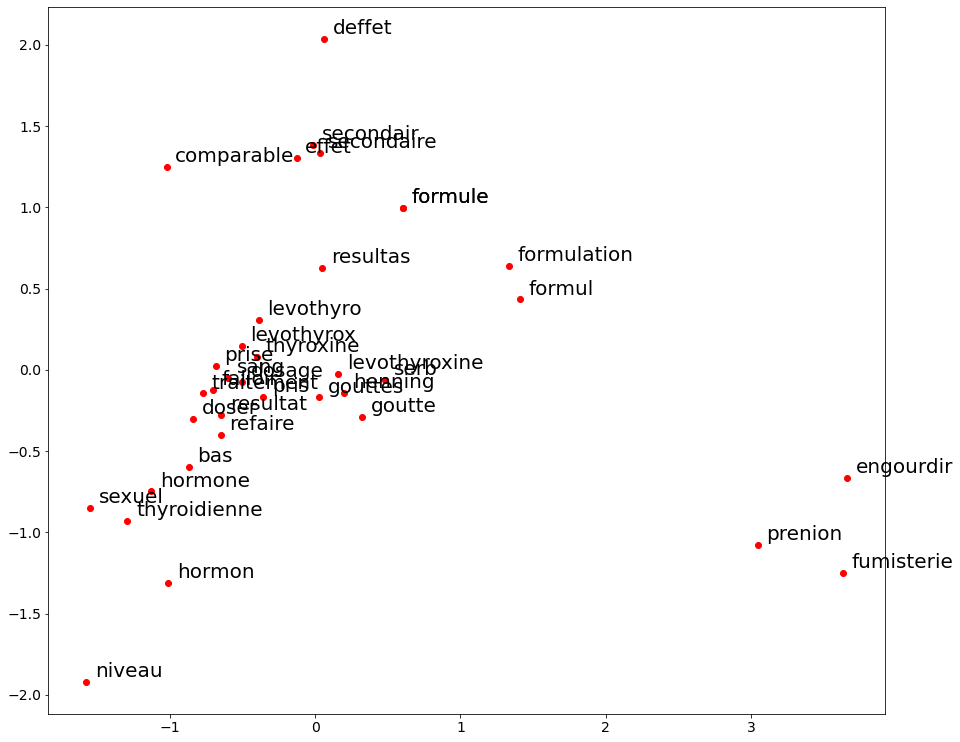

In [ ]:
semantic_similarity_analysis(ft_model_all,dir+"Figures/word_rep_all.png")


### Year 2020

In [ ]:
# Fasttext (Word2Vec) machine learning model
ft_model_2020 = learn_word_rep(df[df['year']==2020],embedding_size,window_size,min_word,down_sampling,nbiter)



Elapsed time 9.683465719223022 s



Keyed vectors for levotyrox
[-2.03664258e-01 -4.43268269e-01  2.31311500e-01 -1.19771254e+00
  1.51130438e-01 -4.35180664e-01 -2.56362766e-01 -2.95701504e-01
  1.18862547e-01  2.17531621e-02 -7.03717649e-01  6.71455026e-01
  1.27438068e-01  3.61688465e-01 -1.75125793e-01  3.81122559e-01
 -7.45912433e-01 -2.37815324e-02 -1.07988074e-01 -3.27081025e-01
  2.30510220e-01  3.18168372e-01  3.21411528e-02 -5.26283920e-01
  1.67533264e-01 -5.72242178e-02 -5.61248243e-01  6.07150495e-02
 -2.49003053e-01 -3.18309873e-01  2.90015370e-01 -3.76315922e-01
  3.25975642e-02  7.32846558e-01  2.89980415e-02  2.34028354e-01
 -5.26762642e-02 -1.06923236e-03 -1.93161160e-01 -2.94707209e-01
 -5.28239533e-02 -4.24066007e-01 -5.75525761e-01 -1.06246293e-01
 -6.78166747e-01  5.61244011e-01  7.27763772e-02 -2.23682672e-01
  2.61535674e-01 -1.62956595e-01 -4.43619601e-02 -3.31223875e-01
 -4.85935807e-01  3.82161617e-01  2.48316377e-01 -4.74357128e-01
 -3.99383247e-01  4.11138594e-01  3.21605206e-02  5.31051934e

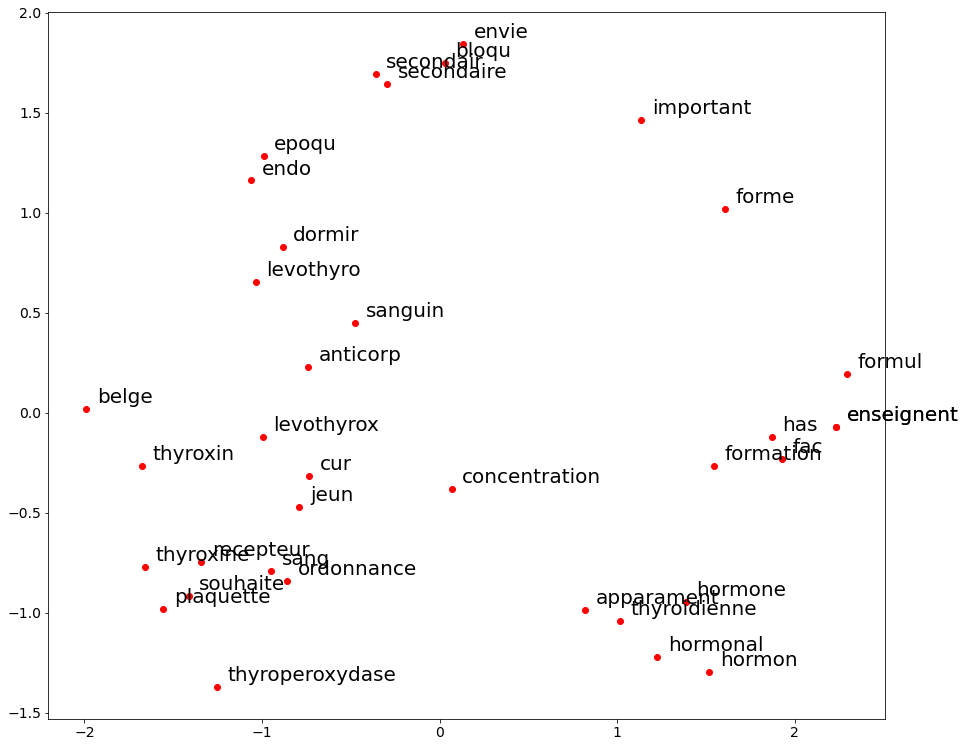

In [ ]:
semantic_similarity_analysis(ft_model_2020,dir+"Figures/word_rep_2020.png")

### Year 2019

In [ ]:
# Fasttext (Word2Vec) machine learning model
ft_model_2019 = learn_word_rep(df[df['year']==2019],embedding_size,window_size,min_word,down_sampling,nbiter)



Elapsed time 35.4725501537323 s



Keyed vectors for levotyrox
[-0.09045051  0.16024804  0.0808468  -0.16796783 -0.3371341   0.1524376
  0.17686488 -0.5013871   0.0296663  -0.21981497 -0.54665416 -0.3241142
  0.23850678 -0.17701513 -0.2057776   0.11066315  0.42531013 -0.11013249
 -0.21748427 -0.04992987  0.23261715 -0.5718274   0.2633642  -0.16941485
 -0.4319767  -0.21773702  0.26563722  0.2936034  -0.1631158   0.00104915
 -0.33719948 -0.2623005  -0.47432446  0.27695677 -0.06746417  0.4738809
  0.49573398  0.20580302 -0.16494676 -0.23561662 -0.24113004 -0.07380413
 -0.15156043 -0.16494583 -0.5722375  -0.3853941  -0.01031634 -0.13074236
  0.03153818 -0.3266863   0.06880559  0.08677372 -0.06126073  0.5919817
  0.25500184  0.11202525  0.32335576 -0.18593046 -0.35267776 -0.07220614]

Semantically similar words to ['levothyrox','formul', 'secondair', 'sang', 'thyroxine', 'hormon']
levothyrox:['levothyro', 'prenais', 'agressif', 'fort', 'leger']
formul:['formule', 'formulation', 'ancien', 'britannique', 'merck']
secondair:['

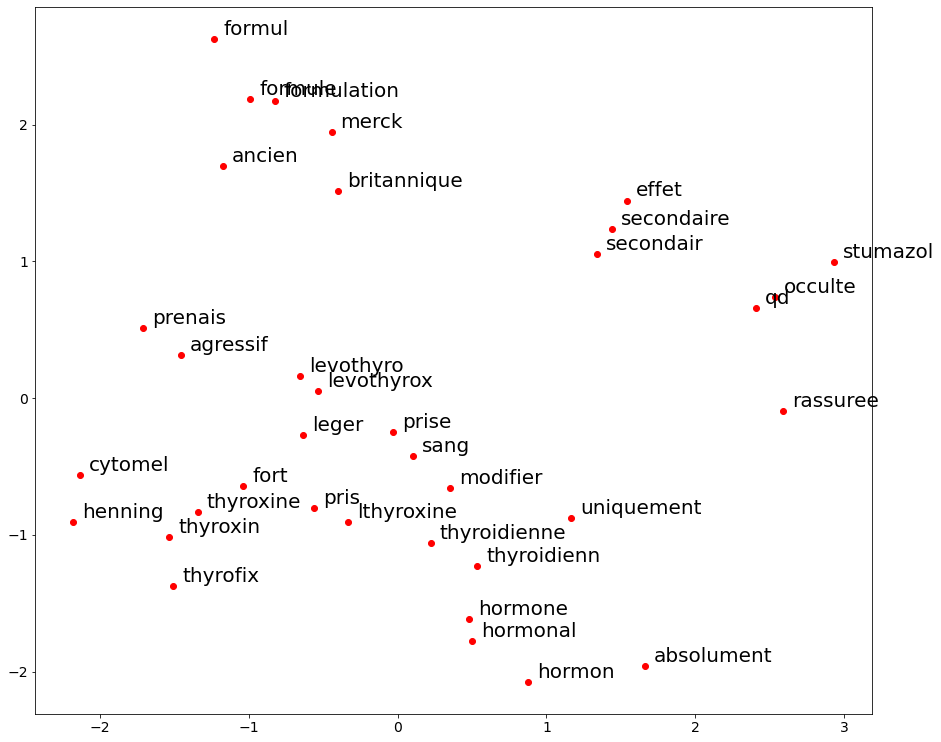

In [ ]:
semantic_similarity_analysis(ft_model_2019,dir+"Figures/word_rep_2019.png")

### 2018

In [ ]:
# Fasttext (Word2Vec) machine learning model
ft_model_2018 = learn_word_rep(df[df['year']==2018],embedding_size,window_size,min_word,down_sampling,nbiter)



Elapsed time 79.10035610198975 s



Keyed vectors for levotyrox
[-0.0461036   0.07724988 -0.17963175  0.27244607  0.19552796  0.30357662
  0.13535477 -0.15636112 -0.06981068 -0.16032915 -0.30771837  0.06333525
  0.15544279  0.07998767  0.05497808 -0.34959596 -0.05416673  0.13081758
  0.32199582 -0.18121818  0.30713207 -0.08429535  0.21308057  0.06987384
 -0.02574974  0.38043797 -0.13658084 -0.2742772   0.28157946  0.3156961
 -0.10443079  0.56447124  0.08169717  0.40856463  0.00805368 -0.18532361
 -0.0586147  -0.45461056 -0.4116003   0.0491186   0.28860793 -0.11250586
 -0.19328262  0.17000932 -0.15518643  0.02366852  0.28105447 -0.29787892
 -0.07814074  0.07154395 -0.28570527  0.20759194 -0.30325112 -0.22592509
  0.18662202  0.0566444   0.20901088  0.06488233  0.33146727 -0.06104172]

Semantically similar words to ['levothyrox','formul', 'secondair', 'sang', 'thyroxine', 'hormon']
levothyrox:['levothyro', 'controle', 'ajuster', 'doser', 'suppose']
formul:['formule', 'ancien', 'nouveau', 'euthyrox', 'rapporte']
secondair:

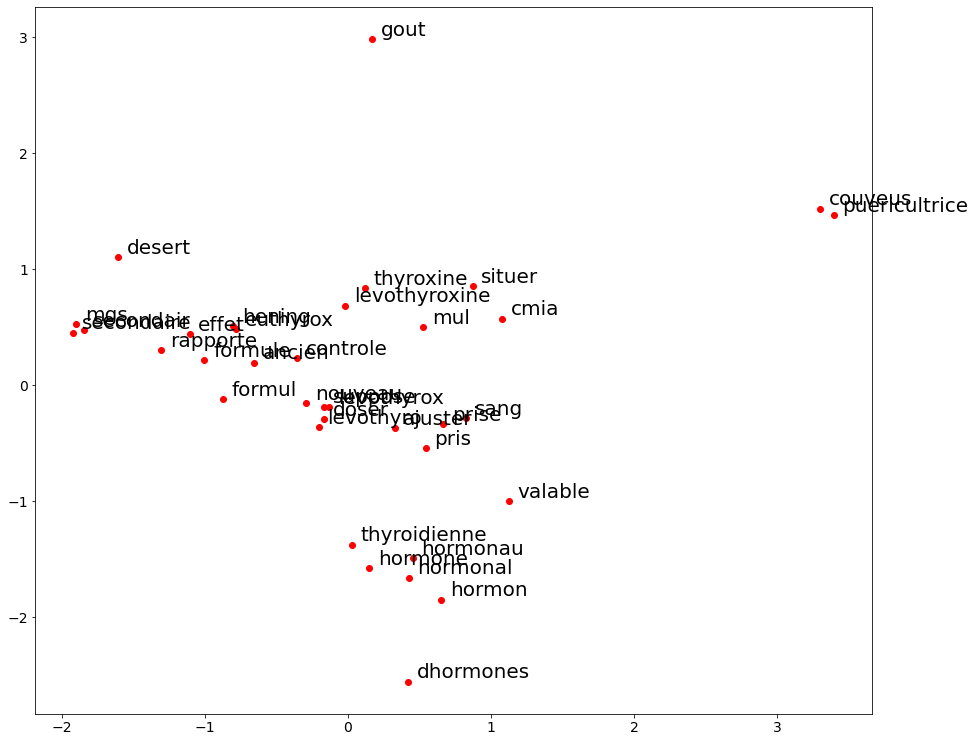

In [ ]:
semantic_similarity_analysis(ft_model_2018,dir+"Figures/word_rep_2018.png")

### 2017

In [ ]:
# Fasttext (Word2Vec) machine learning model
ft_model_2017 = learn_word_rep(df[df['year']==2017],embedding_size,window_size,min_word,down_sampling,nbiter)



Elapsed time 172.36765694618225 s



Keyed vectors for levotyrox
[ 0.04668248  0.07513385  0.11920212 -0.22378416  0.4527863  -0.10132505
 -0.29257563 -0.03124586 -0.30727527 -0.45293823  0.2358946   0.04389469
 -0.1446698  -0.14991419 -0.18413697  0.26308888 -0.07359382 -0.31532645
  0.4089172  -0.06273121  0.11165182  0.00931126  0.07192114  0.12717937
  0.0835117  -0.08521031  0.17656033 -0.26301065  0.09592339  0.28263783
 -0.24758786 -0.11284126  0.10025283  0.15131497 -0.02995984 -0.25928044
  0.01617415  0.01662075 -0.25588083  0.08038291  0.19123785  0.13738123
 -0.17112072  0.29579255 -0.24094072 -0.17728512  0.0823639   0.03634435
  0.17155094  0.14782771 -0.12340359  0.09821186  0.21772671 -0.00959631
  0.3100889   0.05826548 -0.43804404  0.07163913 -0.19832705  0.00535715]

Semantically similar words to ['levothyrox','formul', 'secondair', 'sang', 'thyroxine', 'hormon']
levothyrox:['semaine', 'apportee', 'demeur', 'enonce', 'falloir']
formul:['sournois', 'vaste', 'engourdir', 'moui', 'fumisterie']
secondair:[

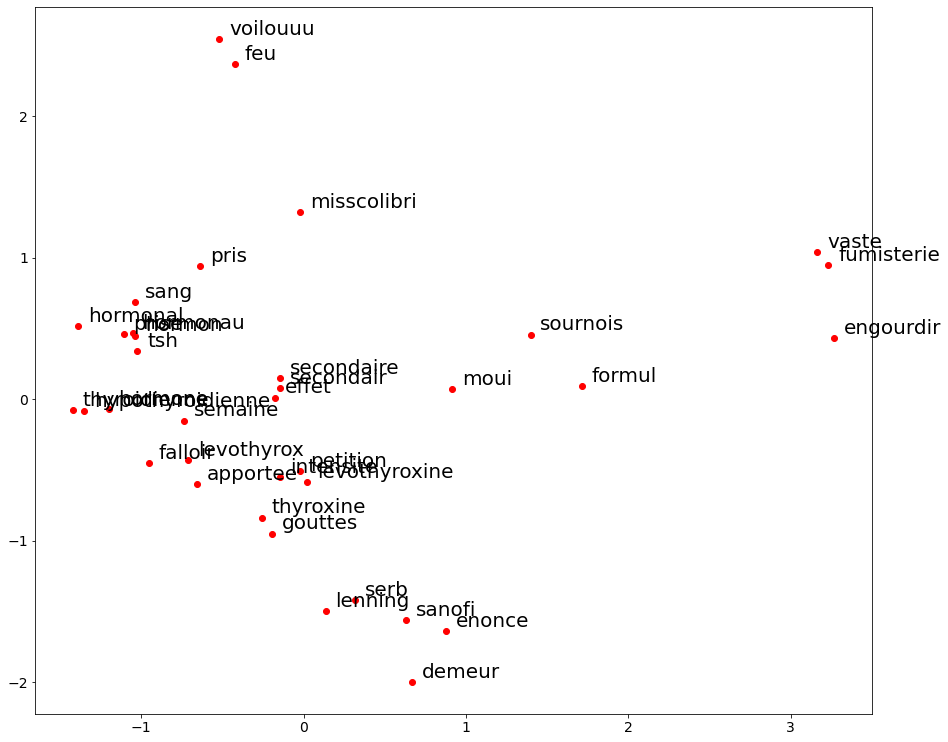

In [ ]:
semantic_similarity_analysis(ft_model_2017,dir+"Figures/word_rep_2017.png")

### 2016

In [ ]:
# Fasttext (Word2Vec) machine learning model
ft_model_2016 = learn_word_rep(df[df['year']==2016],embedding_size,window_size,min_word,down_sampling,nbiter)



Elapsed time 67.40204119682312 s



Keyed vectors for levotyrox
[ 0.29356372  0.21419176 -0.6364874   0.01667854 -0.04108495  0.0497693
  0.11117043 -0.01059621  0.16126521  0.3549957   0.21315672  0.17789043
 -0.12347363  0.12384117 -0.21655074 -0.04600917 -0.13539024 -0.28940547
 -0.17639714 -0.20592411 -0.13152531  0.16829439 -0.04763958  0.10284312
  0.49120522 -0.1171622  -0.13288021 -0.1664741   0.2817528  -0.28084117
  0.36748323 -0.05412378  0.37120613 -0.06058713  0.24286494  0.08172544
  0.4028391  -0.04196335  0.41671276 -0.1485834  -0.04326434  0.03535885
 -0.11032331  0.02860701 -0.00396491  0.02332127  0.10472322 -0.21562125
 -0.06297297  0.4119034  -0.26219422 -0.14889833 -0.237022    0.17029761
 -0.19354776 -0.09852835 -0.30383644 -0.44374403  0.19887574  0.09278598]

Semantically similar words to ['levothyrox','formul', 'secondair', 'sang', 'thyroxine', 'hormon']
levothyrox:['doser', 'fallu', 'prescription', 'levothyro', 'augment']
formul:['format', 'forme', 'mul', 'mm', 'formation']
secondair:['seconda

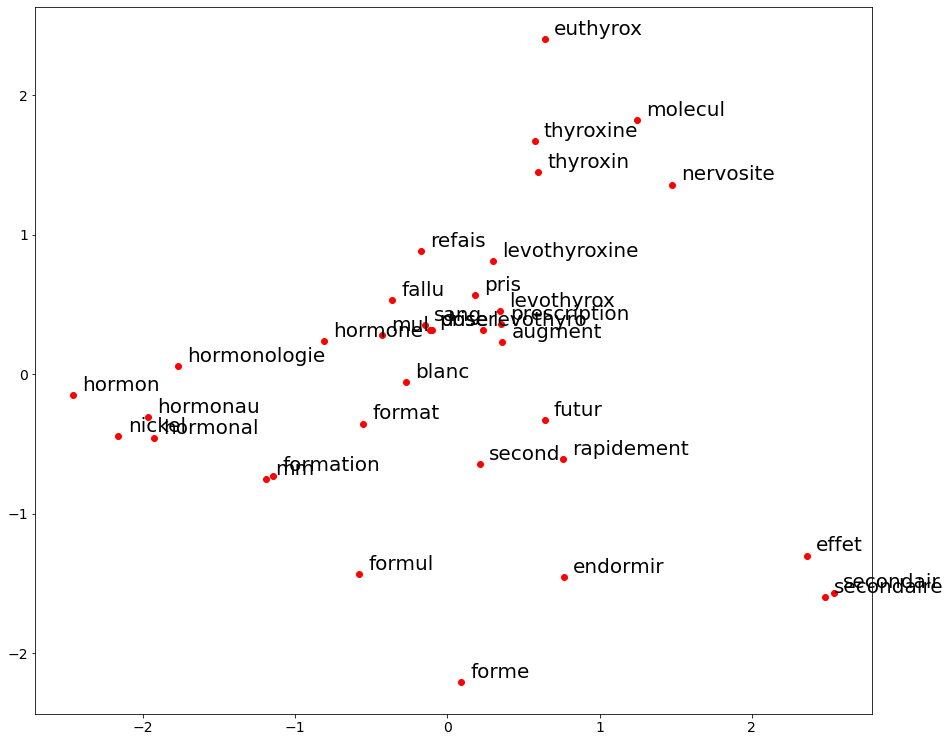

In [ ]:
semantic_similarity_analysis(ft_model_2016,dir+"Figures/word_rep_2016.png")

### All
Similarity levothyrox / secondair 0.51866055
Similarity levothyrox / formul 0.4111738
Similarity nouveau / secondair 0.57843894
Similarity ancien / secondair 0.6007814
Similarity formul / secondair 0.5160921

### 2016
Similarity levothyrox / secondair 0.4288943
Similarity levothyrox / formul 0.32274163
Similarity nouveau / secondair 0.16345647
Similarity ancien / secondair 0.1698635
Similarity formul / secondair 0.39607477

### 2017
Similarity levothyrox / secondair 0.3518962
Similarity levothyrox / formul 0.33772412
Similarity nouveau / secondair 0.46180317
Similarity ancien / secondair 0.49759233
Similarity formul / secondair 0.47623107

### 2018 
Similarity levothyrox / secondair 0.32293212
Similarity levothyrox / formul 0.4808521
Similarity nouveau / secondair 0.33963794
Similarity ancien / secondair 0.36763996
Similarity formul / secondair 0.4760575

### 2019 
Similarity levothyrox / secondair 0.32378528
Similarity levothyrox / formul 0.4493349
Similarity nouveau / secondair 0.3161796
Similarity ancien / secondair 0.29585385
Similarity formul / secondair 0.32000828

### 2020
Similarity levothyrox / secondair 0.20540437
Similarity levothyrox / formul 0.18615992
Similarity nouveau / secondair 0.24588758
Similarity ancien / secondair 0.1859299
Similarity formul / secondair 0.3372865

In [ ]:
  
import pandas as pd
  
# initialize data of lists.
data = {'Levothyrox Secondaire':[0.51866055,0.20540437, 0.32378528,0.32293212,0.3518962,0.4288943],
        'Levothyrox Formule': [0.4111738, 0.18615992, 0.4493349, 0.4808521, 0.33772412, 0.32274163],
        'Nouveau Secondaire': [0.57843894, 0.24588758, 0.3161796, 0.33963794, 0.46180317, 0.16345647],
        'Ancien Secondaire': [0.6007814, 0.1859299, 0.29585385, 0.36763996, 0.49759233, 0.1698635],
        'Formule Secondaire': [0.5160921, 0.3372865, 0.32000828, 0.4760575, 0.47623107, 0.39607477],
        'Year':['2016-2020', '2020' , '2019', '2018','2017','2016']}


# Create DataFrame
df_SS = pd.DataFrame(data)
  
# Print the output.
df_SS



,Levothyrox Secondaire,Levothyrox Formule,Nouveau Secondaire,Ancien Secondaire,Formule Secondaire,Year
0,0.518661,0.411174,0.578439,0.600781,0.516092,2016-2020
1,0.205404,0.186160,0.245888,0.185930,0.337286,2020
2,0.323785,0.449335,0.316180,0.295854,0.320008,2019
3,0.322932,0.480852,0.339638,0.367640,0.476058,2018
4,0.351896,0.337724,0.461803,0.497592,0.476231,2017
5,0.428894,0.322742,0.163456,0.169864,0.396075,2016


<AxesSubplot:>

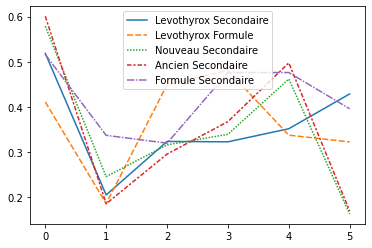

In [ ]:
import seaborn as sns
sns.lineplot(data=df_SS)


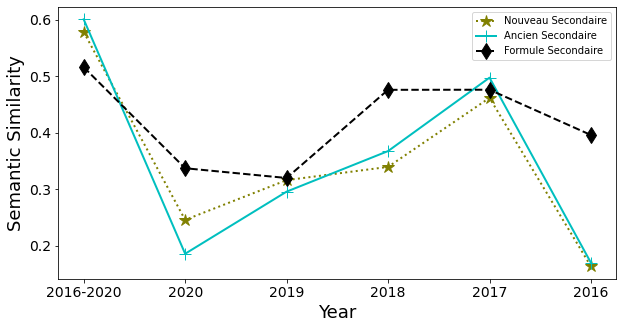

In [ ]:
# libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

plt.figure(figsize=(10, 5))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# multiple line plots
#plt.plot( 'Year', 'Levothyrox Secondaire', data=df_SS, marker='o',linestyle='dashed',markersize=12,color='skyblue', linewidth=2, label="Levothyrox Secondaire")#markerfacecolor='blue', markersize=8
#plt.plot( 'Year', 'Levothyrox Formule', data=df_SS, marker='x', linestyle='-.', markersize=12, color='red', linewidth=2, label="Levothyrox Formule")
plt.plot( 'Year', 'Nouveau Secondaire', data=df_SS, marker='*',linestyle=':', markersize=12, color='olive', linewidth=2, label="Nouveau Secondaire")#linestyle='dashed'
plt.plot( 'Year', 'Ancien Secondaire', data=df_SS, marker='+', markersize=12, color='c', linewidth=2, label = 'Ancien Secondaire')
plt.plot( 'Year', 'Formule Secondaire', data=df_SS, marker='d',linestyle='dashed', markersize=12, color='black', linewidth=2, label="Formule Secondaire")
plt.xlabel('Year', fontsize=18)
plt.ylabel('Semantic Similarity', fontsize=18)
  # show legend
plt.legend()
plt.savefig(dir+"Figures/SemanticSimilarity")
  # show graph
plt.show()



In [ ]:
!pip install mpltex

  Created wheel for mpltex: filename=mpltex-0.7-py3-none-any.whl size=15105 sha256=62e5f8d445f765307c961d13e42cf1e357d29cc5d7537c112c69a77145b3bc51
  Stored in directory: /root/.cache/pip/wheels/e5/fb/13/1478cd2edefee466d35a3f1784dc5e38c028e9f3798aa9c973
Successfully built mpltex


# **4) Training and exporting sentiment prediction for Doctissimo dataset**

In [ ]:
# French_tweets
french_tweets = pd.read_csv(dir + 'french_tweets_updated.csv')

# Limit size for initial testing
if not max_tweets is None:
    french_tweets = french_tweets.sample(n=max_tweets)

# Split train/test samples : option 2
train, test = train_test_split(french_tweets, test_size=test_size)

# Save train to csv
train.to_csv(dir + 'train.csv', index=False, sep=' ', header=False, quoting=csv.QUOTE_NONE, quotechar="", escapechar=" ")

model = train_supervised(dir + 'train.csv', epoch=100)

predictions = []
for line in test['text']:
    pred_label = model.predict(line, k=-1, threshold=0.5)[0][0]
    predictions.append(pred_label)

# you add the list to the dataframe, then save the datframe to new csv
test['prediction'] = predictions

s_positive = len(test[test['sentiment']=='__label__positive'].index)
s_negative = len(test[test['sentiment']=='__label__negative'].index)
p_positive = len(test[test['prediction']=='__label__positive'].index)
p_negative = len(test[test['prediction']=='__label__negative'].index)
success = len(test[test['prediction']==test['sentiment']].index)
total = len(test.index)
print(s_positive, s_negative, p_positive, p_negative)
print('Taux succès : ', success/total*100, '%')


# Drop all columns except the 'text' column
df = df[['text']]

predictions=[]
for line in df['text']:
    pred_label = model.predict(line, k=-1, threshold=0.5)[0][0]
    predictions.append(pred_label)

df['prediction'] = predictions
print()
print('All sentiments')
print(df.head())
print()
print('Positive sentiment')
print(df[df['prediction']=='__label__positive'].head())
print()
print('Negative sentiment')
print(df[df['prediction']=='__label__negative'].head())
n_positive = len(df[df['prediction']=='__label__positive'].index)
n_negative = len(df[df['prediction']=='__label__negative'].index)
print('Count positive', n_positive)
print('Count negative', n_negative)

df.to_csv(dir + 'sentiment_prediction.csv')

999 1001 959 1041
Taux succès :  64.2 %

All sentiments
                                                   text         prediction
5323  thyroidite partum accouchement recent thyroidi...  __label__positive
1115  ans suivie thyroide echographie nodule gros de...  __label__negative
5722  hyper resultats contraire hypothyroidie tsh ha...  __label__positive
3821  rebondissements ancien formule levothyrox acce...  __label__positive
1501                       obtenu contact medecin belle  __label__positive

Positive sentiment
                                                   text         prediction
5323  thyroidite partum accouchement recent thyroidi...  __label__positive
5722  hyper resultats contraire hypothyroidie tsh ha...  __label__positive
3821  rebondissements ancien formule levothyrox acce...  __label__positive
1501                       obtenu contact medecin belle  __label__positive
6709  medecin soucis connais endocrinologue depassem...  __label__positive

Negative sentiment
    

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
